# Glaucoma AI Screening Model - Base Case Analysis

This notebook sets up and runs the base case cost-effectiveness analysis comparing AI-enhanced vs traditional glaucoma screening.

---

## Overview

**Objective**: Evaluate the cost-effectiveness of AI-enhanced glaucoma screening compared to traditional screening (no screening baseline).

**Model Structure**:
- **Population**: General population aged 61 (median), 55% male
- **Time Horizon**: 30 years
- **Perspective**: Healthcare system
- **Discount Rates**: 3% for costs and QALYs
- **Iterations**: 5,000 Monte Carlo simulations

**Key Model Features**:
- Markov model with 5 health states: Mild, Moderate, Severe, Visual Impairment (VI), Dead
- AI screening with sensitivity/specificity adjustment
- Accounts for false positives and screening costs
- Age-specific mortality from Swiss life tables (2023)

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

print("✓ Imports complete")

✓ Imports complete


In [2]:
from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Model modules loaded")

Parameter class defined!
Enhanced GlaucomaParameters class defined with state-specific screening accuracy, mortality odds ratios, and false positive disutility!
Enhanced models with age-dependent mortality from life tables defined!
✓ Model modules loaded


## 2. Configuration

Set global parameters for the analysis

In [3]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61  # Median age
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

print("=== BASE CASE CONFIGURATION ===")
print(f"Iterations: {N_ITERATIONS:,}")
print(f"Time horizon: {YEARS} years")
print(f"Starting age: {STARTING_AGE} years")
print(f"Male proportion: {MALE_PROPORTION:.0%}")
print(f"Random seed: {RANDOM_SEED}")

=== BASE CASE CONFIGURATION ===
Iterations: 5,000
Time horizon: 30 years
Starting age: 61 years
Male proportion: 55%
Random seed: 42


## 3. Model Initialization

Initialize AI and Non-AI glaucoma models with mortality tables

In [4]:
# Initialize AI model
model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
model_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv', 
    filepath_female='../data/female_mortality_2023.csv', 
    male_proportion=MALE_PROPORTION
)

# Initialize Non-AI model
model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
model_non_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv',
    filepath_female='../data/female_mortality_2023.csv',
    male_proportion=MALE_PROPORTION
)

print("✓ Models initialized with mortality tables")
print(f"\nAI Model: {model_ai}")
print(f"Non-AI Model: {model_non_ai}")

Applied Non-AI cost structure: Only VI patients incur costs
✓ Models initialized with mortality tables

AI Model: <glaucoma_model.model.AIGlaucomaModel object at 0x0000019EB418F450>
Non-AI Model: <glaucoma_model.model.NonAIGlaucomaModel object at 0x0000019EAE638890>


## 4. Model Parameters Review

Review key parameters for both models

### 4.1 AI Model Parameters

In [5]:
print("=== AI MODEL PARAMETERS ===")
model_ai.params.get_summary()

=== AI MODEL PARAMETERS ===


,Category,Parameter,Mean,Std,Distribution
0,Costs,monitoring_mild,352.000,70.400000,gamma
1,Costs,monitoring_moderate,463.000,92.600000,gamma
2,Costs,monitoring_severe,644.000,128.800000,gamma
3,Costs,monitoring_vi,576.000,115.200000,gamma
4,Costs,treatment_mild,303.000,60.600000,gamma
5,Costs,treatment_moderate,429.000,85.800000,gamma
6,Costs,treatment_severe,609.000,121.800000,gamma
7,Costs,treatment_vi,662.000,132.400000,gamma
8,Costs,other_mild,0.000,0.000000,gamma
9,Costs,other_moderate,0.000,0.000000,gamma


### 4.2 Non-AI Model Parameters

In [6]:
print("=== NON-AI MODEL PARAMETERS ===")
model_non_ai.params.get_summary()

=== NON-AI MODEL PARAMETERS ===


,Category,Parameter,Mean,Std,Distribution
0,Costs,monitoring_mild,0.000,0.000000e+00,gamma
1,Costs,monitoring_moderate,0.000,0.000000e+00,gamma
2,Costs,monitoring_severe,0.000,0.000000e+00,gamma
3,Costs,monitoring_vi,576.000,1.152000e+02,gamma
4,Costs,treatment_mild,0.000,0.000000e+00,gamma
5,Costs,treatment_moderate,0.000,0.000000e+00,gamma
6,Costs,treatment_severe,0.000,0.000000e+00,gamma
7,Costs,treatment_vi,662.000,1.324000e+02,gamma
8,Costs,other_mild,0.000,0.000000e+00,gamma
9,Costs,other_moderate,0.000,0.000000e+00,gamma


## 5. Define Initial Distribution

Set the starting distribution of patients across health states

In [7]:
# Initial distribution: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead
# Based on the prevalence of glaucoma states in the general population
initial_dist = [38, 9, 7, 0, 0]
initial_dist = np.array(initial_dist) / np.sum(initial_dist)

print("=== INITIAL DISTRIBUTION ===")
print(f"Mild:     {initial_dist[0]:.2%}")
print(f"Moderate: {initial_dist[1]:.2%}")
print(f"Severe:   {initial_dist[2]:.2%}")
print(f"VI:       {initial_dist[3]:.2%}")
print(f"Dead:     {initial_dist[4]:.2%}")
print(f"\nTotal:    {np.sum(initial_dist):.2%}")

=== INITIAL DISTRIBUTION ===
Mild:     70.37%
Moderate: 16.67%
Severe:   12.96%
VI:       0.00%
Dead:     0.00%

Total:    100.00%


## 6. Run Probabilistic Sensitivity Analysis (PSA)

Run Monte Carlo simulations for both AI and Non-AI models

### 6.1 AI Model PSA

In [8]:
print(f"Running AI Model PSA with {N_ITERATIONS:,} iterations...")

ai_psa_results = model_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print("✓ AI Model PSA complete")
print(f"\nTrace tensor shape: {ai_psa_results['trace_tensor'].shape}")
print(f"Variables tracked: {len(ai_psa_results['trace_variable_names'])}")

Running AI Model PSA with 5,000 iterations...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  AI Model Iteration 2600/5000
  AI Model Iteration 2700/5000
  AI Model Iteration 2800/5000
  AI Model Iteration 29

### 6.2 Non-AI Model PSA

In [9]:
print(f"Running Non-AI Model PSA with {N_ITERATIONS:,} iterations...")

non_ai_psa_results = model_non_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print("✓ Non-AI Model PSA complete")
print(f"\nTrace tensor shape: {non_ai_psa_results['trace_tensor'].shape}")
print(f"Variables tracked: {len(non_ai_psa_results['trace_variable_names'])}")

Running Non-AI Model PSA with 5,000 iterations...
Running 5000 PSA iterations for Traditional Non-AI Model (Starting Age: 61)...
  Non-AI Model Iteration 100/5000
  Non-AI Model Iteration 200/5000
  Non-AI Model Iteration 300/5000
  Non-AI Model Iteration 400/5000
  Non-AI Model Iteration 500/5000
  Non-AI Model Iteration 600/5000
  Non-AI Model Iteration 700/5000
  Non-AI Model Iteration 800/5000
  Non-AI Model Iteration 900/5000
  Non-AI Model Iteration 1000/5000
  Non-AI Model Iteration 1100/5000
  Non-AI Model Iteration 1200/5000
  Non-AI Model Iteration 1300/5000
  Non-AI Model Iteration 1400/5000
  Non-AI Model Iteration 1500/5000
  Non-AI Model Iteration 1600/5000
  Non-AI Model Iteration 1700/5000
  Non-AI Model Iteration 1800/5000
  Non-AI Model Iteration 1900/5000
  Non-AI Model Iteration 2000/5000
  Non-AI Model Iteration 2100/5000
  Non-AI Model Iteration 2200/5000
  Non-AI Model Iteration 2300/5000
  Non-AI Model Iteration 2400/5000
  Non-AI Model Iteration 2500/5000
  Non

## 7. Adjust for AI Screening Sensitivity and Specificity

Account for imperfect sensitivity and specificity of AI screening by blending AI and Non-AI results

In [10]:
print("Adjusting AI results for sensitivity and specificity...")

# Get trace tensors and variable names
ai_traces = ai_psa_results['trace_tensor']
non_ai_traces = non_ai_psa_results['trace_tensor']
trace_variable_names = ai_psa_results['trace_variable_names']

# Create adjusted AI results
ai_eff0_psa_traces = copy.deepcopy(ai_traces)
ai_eff0_psa_results = copy.deepcopy(ai_psa_results)

# Get sensitivity value
sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
specificity_value = model_ai.params.screening_accuracy['specificity'].mean

print(f"\nScreening Performance:")
print(f"  Sensitivity: {sensitivity_value:.1%}")
print(f"  Specificity: {specificity_value:.1%}")

# Adjust costs: weighted average based on sensitivity
print("\nAdjusting costs...")
for var_name in ['Total_Cost', 'Total_Cost_Disc']:
    if var_name in trace_variable_names:
        var_idx = trace_variable_names.index(var_name)
        ai_eff0_psa_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

# Adjust QALYs: weighted average based on sensitivity
print("Adjusting QALYs...")
qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
for var_name in qaly_vars:
    if var_name in trace_variable_names:
        var_idx = trace_variable_names.index(var_name)
        ai_eff0_psa_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces

print("✓ Sensitivity/specificity adjustment complete")

Adjusting AI results for sensitivity and specificity...

Screening Performance:
  Sensitivity: 77.5%
  Specificity: 95.4%

Adjusting costs...
Adjusting QALYs...
✓ Sensitivity/specificity adjustment complete


## 8. Add Screening Costs

Add AI screening costs and false positive follow-up costs at year 0

In [11]:
print("Adding screening costs...")

# Get cost indices
idx_cost = trace_variable_names.index('Total_Cost')
idx_cost_disc = trace_variable_names.index('Total_Cost_Disc')

# Get parameters
prevalence = model_ai.params.screening_params['prevalence_general'].mean
ai_screening_cost = model_ai.params.costs['ai_screening'].mean
human_screening_cost = model_ai.params.costs['human_screening'].mean

print(f"\nScreening Parameters:")
print(f"  Prevalence: {prevalence:.2%}")
print(f"  AI screening cost: €{ai_screening_cost:,.2f}")
print(f"  Human screening cost (for FPs): €{human_screening_cost:,.2f}")

# Calculate per-case costs
ai_screening_per_case = (1/prevalence) * ai_screening_cost
false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity_value)
fp_cost_per_case = false_positives_per_case * human_screening_cost
total_screening_cost = ai_screening_per_case + fp_cost_per_case

print(f"\nPer-Case Screening Costs:")
print(f"  AI screening: €{ai_screening_per_case:,.2f}")
print(f"  False positive rate: {false_positives_per_case:.2%}")
print(f"  False positive cost: €{fp_cost_per_case:,.2f}")
print(f"  Total screening cost: €{total_screening_cost:,.2f}")

# Add screening costs at year 0
ai_eff0_psa_results['trace_tensor'][:, 0, idx_cost] += total_screening_cost
ai_eff0_psa_results['trace_tensor'][:, 0, idx_cost_disc] += total_screening_cost

print("\n✓ Screening costs added to year 0")

Adding screening costs...

Screening Parameters:
  Prevalence: 5.00%
  AI screening cost: €11.65
  Human screening cost (for FPs): €215.00

Per-Case Screening Costs:
  AI screening: €233.00
  False positive rate: 87.40%
  False positive cost: €187.91
  Total screening cost: €420.91

✓ Screening costs added to year 0


## 9. Trace Analysis

Calculate mean traces across all iterations for visualization

In [12]:
# Calculate mean traces
mean_traces_ai = np.mean(ai_eff0_psa_results['trace_tensor'], axis=0)
mean_traces_non_ai = np.mean(non_ai_psa_results['trace_tensor'], axis=0)

# Convert to DataFrames for easy access
mean_traces_df_ai = pd.DataFrame(
    mean_traces_ai,
    columns=trace_variable_names
)

mean_traces_df_non_ai = pd.DataFrame(
    mean_traces_non_ai,
    columns=trace_variable_names
)

print("✓ Mean traces calculated")
print(f"\nAvailable variables: {', '.join(trace_variable_names)}")

✓ Mean traces calculated

Available variables: Year, Age, Prop_Mild, Prop_Moderate, Prop_Severe, Prop_VI, Prop_Dead, Prop_Alive, Total_Cost, Total_QALY, Total_Cost_Disc, Total_QALY_Disc, Screening_Cost, Cost_Mild, Cost_Moderate, Cost_Severe, Cost_VI, QALY_Mild, QALY_Moderate, QALY_Severe, QALY_VI, Cost_Discount_Factor, Health_Discount_Factor, Mortality_Rate_Mild, Mortality_Rate_Moderate, Mortality_Rate_Severe, Mortality_Rate_VI, Base_Mortality_qx


## 10. Visualizations

Visualize key outcomes over time

### 10.1 Cost Trajectories

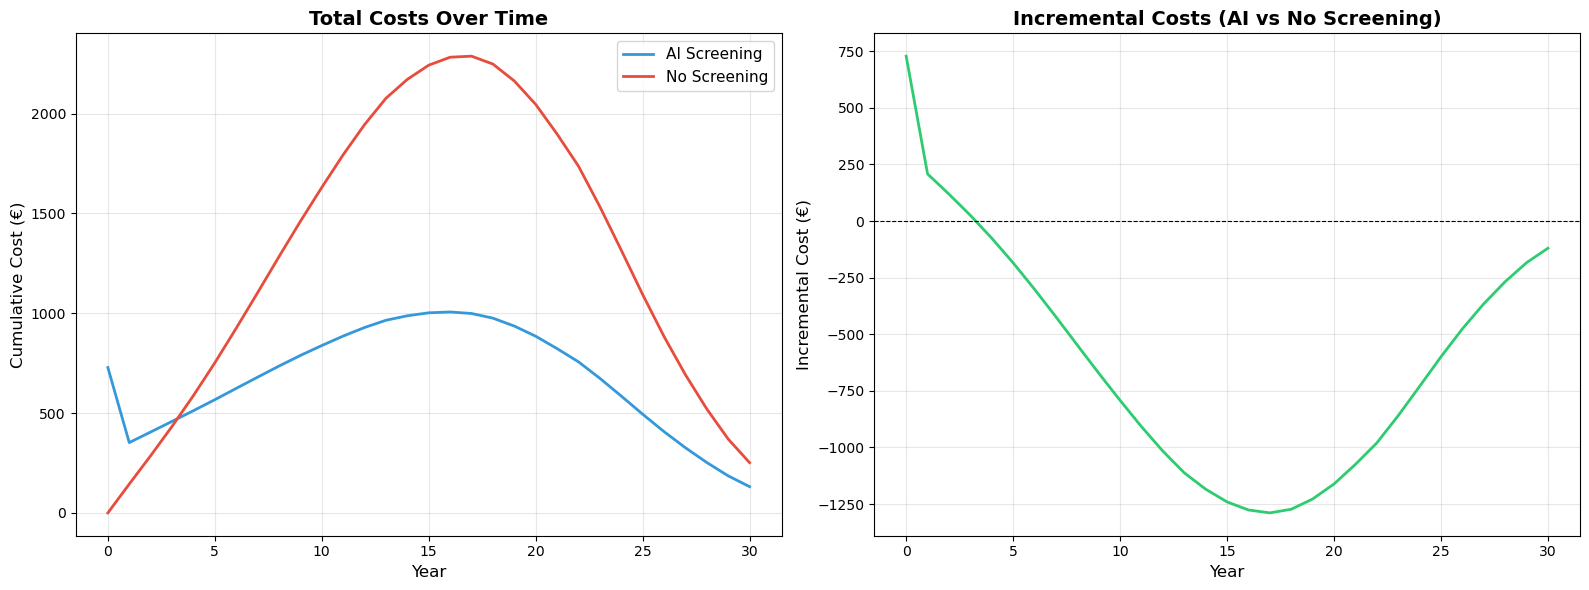


Final incremental cost: €-120


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total costs comparison
years_axis = range(YEARS + 1)
ax1.plot(years_axis, mean_traces_df_ai['Total_Cost'], label='AI Screening', linewidth=2, color='#3498db')
ax1.plot(years_axis, mean_traces_df_non_ai['Total_Cost'], label='No Screening', linewidth=2, color='#e74c3c')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Cumulative Cost (€)', fontsize=12)
ax1.set_title('Total Costs Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Incremental costs
incremental_costs = mean_traces_df_ai['Total_Cost'] - mean_traces_df_non_ai['Total_Cost']
ax2.plot(years_axis, incremental_costs, linewidth=2, color='#2ecc71')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Incremental Cost (€)', fontsize=12)
ax2.set_title('Incremental Costs (AI vs No Screening)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal incremental cost: €{incremental_costs.iloc[-1]:,.0f}")

### 10.2 QALY Trajectories

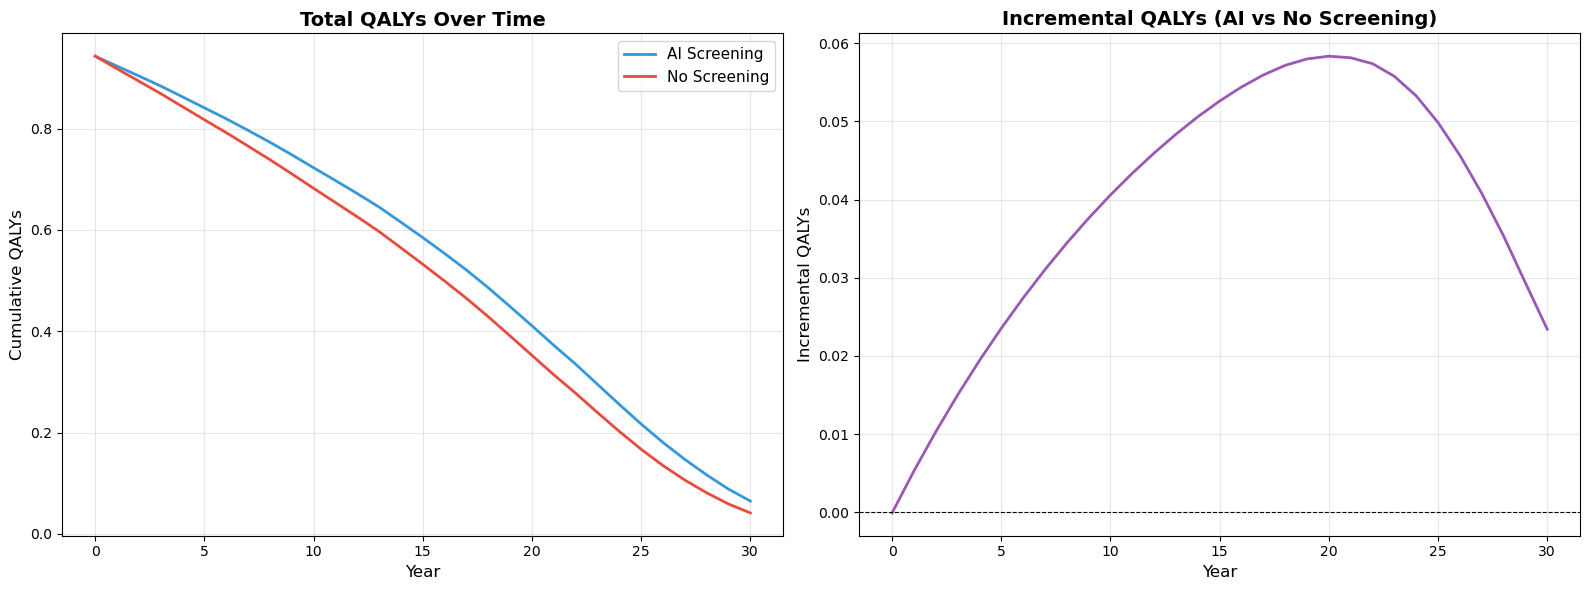


Final incremental QALYs: 0.0234


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total QALYs comparison
ax1.plot(years_axis, mean_traces_df_ai['Total_QALY'], label='AI Screening', linewidth=2, color='#3498db')
ax1.plot(years_axis, mean_traces_df_non_ai['Total_QALY'], label='No Screening', linewidth=2, color='#e74c3c')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Cumulative QALYs', fontsize=12)
ax1.set_title('Total QALYs Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Incremental QALYs
incremental_qalys = mean_traces_df_ai['Total_QALY'] - mean_traces_df_non_ai['Total_QALY']
ax2.plot(years_axis, incremental_qalys, linewidth=2, color='#9b59b6')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Incremental QALYs', fontsize=12)
ax2.set_title('Incremental QALYs (AI vs No Screening)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal incremental QALYs: {incremental_qalys.iloc[-1]:.4f}")

### 10.3 Health State Distribution Over Time

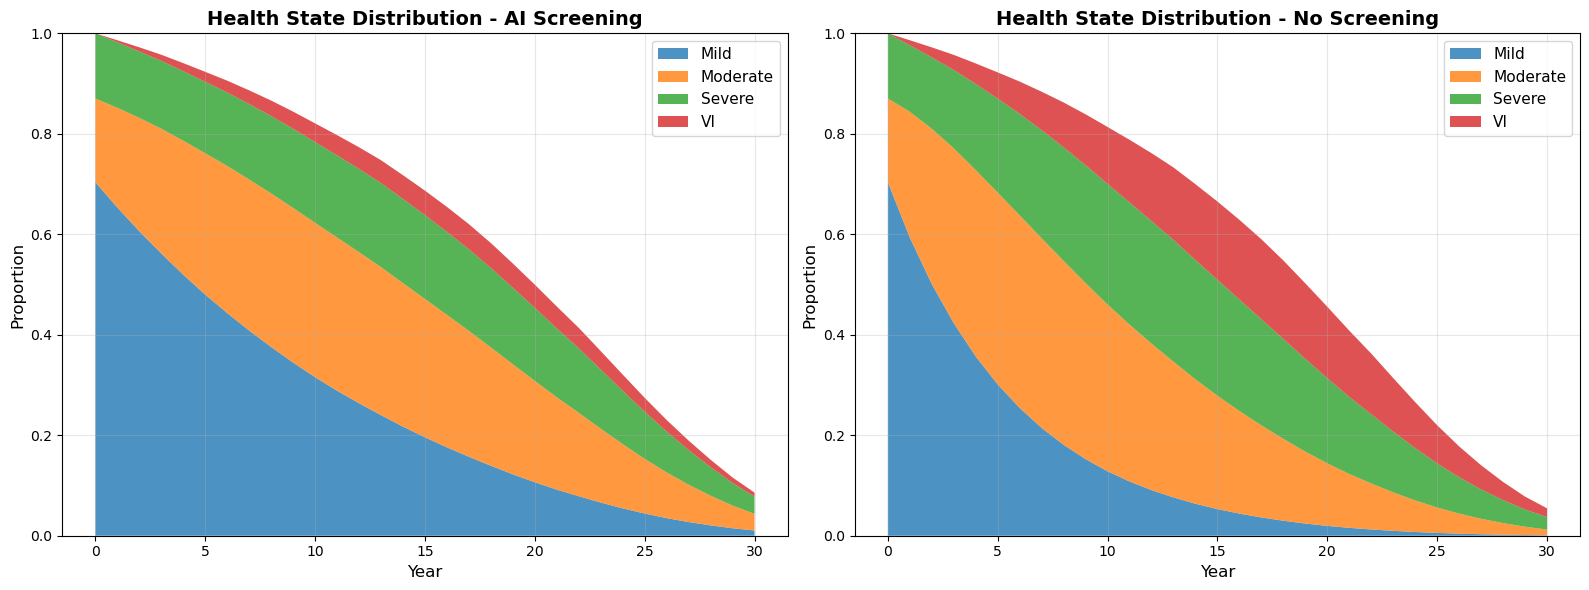

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# AI model health states
health_states = ['Mild', 'Moderate', 'Severe', 'VI']
ax1.stackplot(
    years_axis,
    mean_traces_df_ai['Prop_Mild'],
    mean_traces_df_ai['Prop_Moderate'],
    mean_traces_df_ai['Prop_Severe'],
    mean_traces_df_ai['Prop_VI'],
    labels=health_states,
    alpha=0.8
)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_title('Health State Distribution - AI Screening', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.set_ylim(0, 1)
ax1.grid(alpha=0.3)

# Non-AI model health states
ax2.stackplot(
    years_axis,
    mean_traces_df_non_ai['Prop_Mild'],
    mean_traces_df_non_ai['Prop_Moderate'],
    mean_traces_df_non_ai['Prop_Severe'],
    mean_traces_df_non_ai['Prop_VI'],
    labels=health_states,
    alpha=0.8
)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Proportion', fontsize=12)
ax2.set_title('Health State Distribution - No Screening', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=11)
ax2.set_ylim(0, 1)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Cost-Effectiveness Analysis

Calculate ICERs and cost-effectiveness probabilities across multiple time horizons

In [16]:
print("Running comprehensive cost-effectiveness analysis...")

comprehensive_results = comprehensive_cost_effectiveness_analysis(
    ai_eff0_psa_results,
    non_ai_psa_results,
    time_horizons=[5, 10, 15, 20, 30],
    thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
    confidence_level=0.95,
    discounted=True
)

print("✓ Cost-effectiveness analysis complete")

Running comprehensive cost-effectiveness analysis...
Analyzing 5-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4903 out of 5000
Mean ICER: 2948.64
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4926 out of 5000
Mean ICER: -2121.74
Analyzing 15-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4915 out of 5000
Mean ICER: -6588.02
Analyzing 20-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4920 out of 5000
Mean ICER: -9270.93
Analyzing 30-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4939 out of 5000
Mean ICER: -10457.24
✓ Cost-effectiveness analysis complete


## 12. Results Summary

Generate comprehensive summary table

In [17]:
summary_table = create_summary_table(comprehensive_results)

print("\n" + "="*100)
print("BASE CASE RESULTS SUMMARY")
print("="*100)
print(summary_table.to_string(index=False))

# Display as DataFrame
display(summary_table)


BASE CASE RESULTS SUMMARY
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]       95.0%       95.8%        96.0%
    30 years      

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


## 13. Key Findings

Highlight important results for different time horizons

In [21]:
print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

for horizon in [5, 10, 30]:
    results = comprehensive_results[f'{horizon}_years']['summary']
    
    print(f"\n{'='*50}")
    print(f"{horizon}-YEAR RESULTS")
    print(f"{'='*50}")
    print(f"ICER: €{results['icer_mean']:,.0f}/QALY")
    print(f"  95% CI: [€{results['icer_ci'][0]:,.0f}, €{results['icer_ci'][1]:,.0f}]")
    print(f"\nIncremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"  95% CI: [€{results['incremental_cost_ci'][0]:,.0f}, €{results['incremental_cost_ci'][1]:,.0f}]")
    print(f"\nIncremental QALYs: {results['incremental_qaly_mean']:.4f}")
    print(f"  95% CI: [{results['incremental_qaly_ci'][0]:.4f}, {results['incremental_qaly_ci'][1]:.4f}]")
    print(f"\nProbability Cost-Effective:")
    print(f"  At €20,000/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"  At €50,000/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"  At €100,000/QALY: {results['prob_cost_effective_100k']:.1f}%")


KEY FINDINGS

5-YEAR RESULTS
ICER: €2,949/QALY
  95% CI: [€-149,461, €133,426]

Incremental Cost: €817
  95% CI: [€-1,902, €3,569]

Incremental QALYs: 0.0702
  95% CI: [-0.1917, 0.3279]

Probability Cost-Effective:
  At €20,000/QALY: 64.7%
  At €50,000/QALY: 76.9%
  At €100,000/QALY: 81.3%

10-YEAR RESULTS
ICER: €-2,122/QALY
  95% CI: [€-127,559, €123,218]

Incremental Cost: €-1,315
  95% CI: [€-7,939, €4,944]

Incremental QALYs: 0.2223
  95% CI: [-0.3575, 0.7888]

Probability Cost-Effective:
  At €20,000/QALY: 83.3%
  At €50,000/QALY: 87.9%
  At €100,000/QALY: 89.3%

30-YEAR RESULTS
ICER: €-10,457/QALY
  95% CI: [€-105,881, €81,338]

Incremental Cost: €-11,683
  95% CI: [€-30,396, €5,448]

Incremental QALYs: 0.9548
  95% CI: [-0.7722, 2.5806]

Probability Cost-Effective:
  At €20,000/QALY: 96.6%
  At €50,000/QALY: 97.1%
  At €100,000/QALY: 97.2%


## 14. Cost-Effectiveness Plane

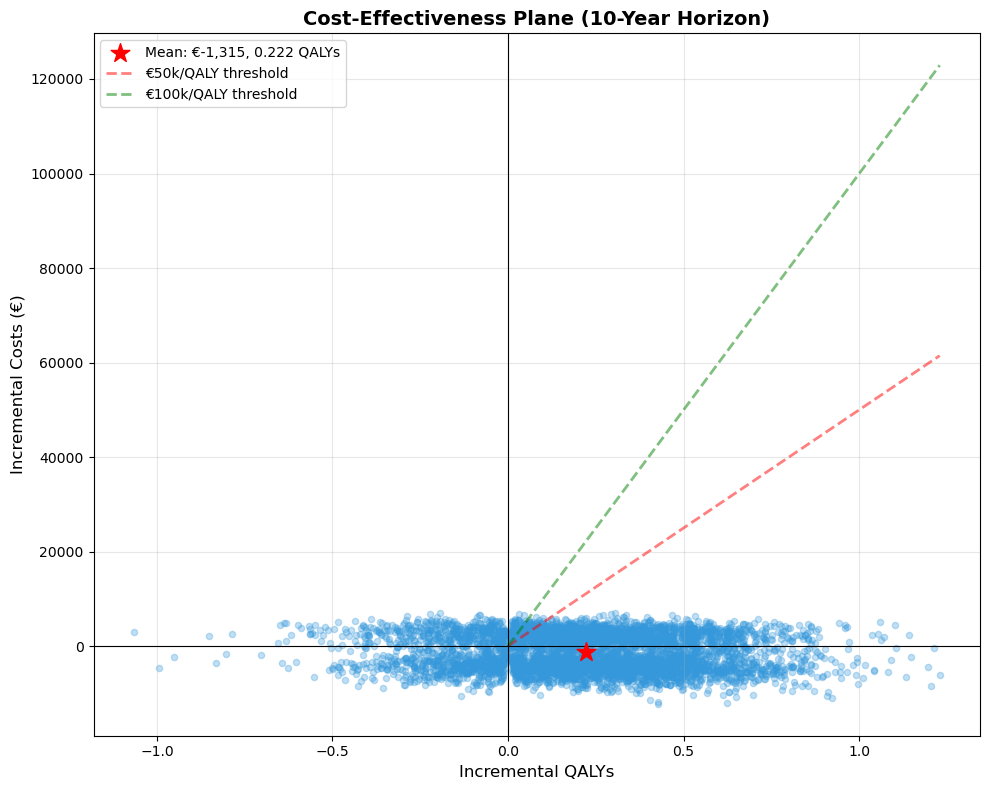

In [27]:
# Get 10-year results for CE plane
results_10y = comprehensive_results['10_years']
inc_costs = results_10y['icer_analysis']['incremental_costs']
inc_qalys = results_10y['icer_analysis']['incremental_qalys']

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot
ax.scatter(inc_qalys, inc_costs, alpha=0.3, s=20, color='#3498db')

# Add mean point
mean_qaly = results_10y['summary']['incremental_qaly_mean']
mean_cost = results_10y['summary']['incremental_cost_mean']
ax.scatter(mean_qaly, mean_cost, s=200, color='red', marker='*', 
           label=f'Mean: €{mean_cost:,.0f}, {mean_qaly:.3f} QALYs', zorder=5)

# Add WTP threshold lines
qaly_range = np.array([0, max(inc_qalys)])
ax.plot(qaly_range, 50000 * qaly_range, 'r--', linewidth=2, alpha=0.5, label='€50k/QALY threshold')
ax.plot(qaly_range, 100000 * qaly_range, 'g--', linewidth=2, alpha=0.5, label='€100k/QALY threshold')

# Format plot
ax.axhline(y=0, color='black', linewidth=0.8)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Incremental QALYs', fontsize=12)
ax.set_ylabel('Incremental Costs (€)', fontsize=12)
ax.set_title('Cost-Effectiveness Plane (10-Year Horizon)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Cost-Effectiveness Acceptability Curve

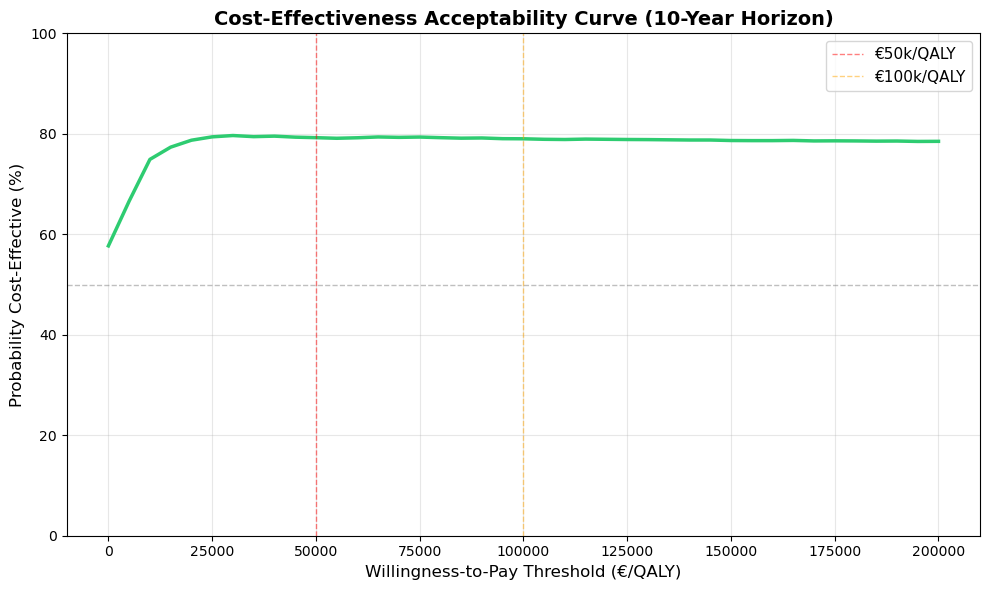

In [30]:
# Calculate CEAC for 10-year horizon
def calculate_ceac(incremental_costs, incremental_qalys, wtp_thresholds):
    """
    Calculate cost-effectiveness acceptability curve
    
    Parameters:
    -----------
    incremental_costs : array
        Array of incremental costs from PSA
    incremental_qalys : array
        Array of incremental QALYs from PSA
    wtp_thresholds : array
        Array of willingness-to-pay thresholds to evaluate
    
    Returns:
    --------
    dict with 'thresholds' and 'probabilities'
    """
    probabilities = []
    
    for wtp in wtp_thresholds:
        # Calculate incremental net monetary benefit for each iteration
        inmb = incremental_qalys * wtp - incremental_costs
        
        # Proportion of iterations where INMB > 0
        prob_ce = (inmb > 0).sum() / len(inmb) * 100
        probabilities.append(prob_ce)
    
    return {
        'thresholds': wtp_thresholds,
        'probabilities': probabilities
    }

# Use it like this:
results_10y = comprehensive_results['10_years']
inc_costs = results_10y['icer_analysis']['incremental_costs']
inc_qalys = results_10y['icer_analysis']['incremental_qalys']

# Define WTP thresholds (you can adjust this range)
wtp_thresholds = np.arange(0, 200001, 5000)  # 0 to 200k in 5k increments

# Calculate CEAC
ceac_data = calculate_ceac(inc_costs, inc_qalys, wtp_thresholds)

# Now plot it
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ceac_data['thresholds'], ceac_data['probabilities'], 
        linewidth=2.5, color='#2ecc71')

# Add reference lines
ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=50000, color='red', linestyle='--', linewidth=1, alpha=0.5, label='€50k/QALY')
ax.axvline(x=100000, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='€100k/QALY')

ax.set_xlabel('Willingness-to-Pay Threshold (€/QALY)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Cost-Effectiveness Acceptability Curve (10-Year Horizon)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Save Results

Save summary table and key results to files

In [31]:
# Save summary table
summary_table.to_csv('../data/base_case_summary.csv', index=False)
print("✓ Summary table saved to ../data/base_case_summary.csv")

# Save detailed results
import pickle
with open('../data/base_case_comprehensive_results.pkl', 'wb') as f:
    pickle.dump(comprehensive_results, f)
print("✓ Comprehensive results saved to ../data/base_case_comprehensive_results.pkl")

# Save trace data
mean_traces_df_ai.to_csv('../data/base_case_traces_ai.csv', index=False)
mean_traces_df_non_ai.to_csv('../data/base_case_traces_non_ai.csv', index=False)
print("✓ Trace data saved")

✓ Summary table saved to ../data/base_case_summary.csv
✓ Comprehensive results saved to ../data/base_case_comprehensive_results.pkl
✓ Trace data saved


## 17. Conclusions

Summary of base case findings

In [33]:
# Get 10-year results for conclusions
res_10y = comprehensive_results['10_years']['summary']

print("\n" + "="*100)
print("BASE CASE CONCLUSIONS (10-YEAR HORIZON)")
print("="*100)

print(f"\n1. COST-EFFECTIVENESS")
print(f"   ICER: €{res_10y['icer_mean']:,.0f}/QALY")
if res_10y['icer_mean'] < 50000:
    print(f"   → AI screening is COST-EFFECTIVE at €50,000/QALY threshold")
elif res_10y['icer_mean'] < 100000:
    print(f"   → AI screening is POTENTIALLY COST-EFFECTIVE (between €50k-€100k/QALY)")
else:
    print(f"   → AI screening is NOT COST-EFFECTIVE at conventional thresholds")

print(f"\n2. INCREMENTAL OUTCOMES")
print(f"   Additional cost: €{res_10y['incremental_cost_mean']:,.0f}")
print(f"   Additional QALYs: {res_10y['incremental_qaly_mean']:.4f}")

print(f"\n3. UNCERTAINTY")
print(f"   Probability cost-effective at €50k/QALY: {res_10y['prob_cost_effective_50k']:.1f}%")
if res_10y['prob_cost_effective_50k'] > 80:
    print(f"   → HIGH confidence in cost-effectiveness")
elif res_10y['prob_cost_effective_50k'] > 50:
    print(f"   → MODERATE confidence in cost-effectiveness")
else:
    print(f"   → LOW confidence in cost-effectiveness")

print(f"\n4. NEXT STEPS")
print(f"   → Conduct sensitivity analyses on key parameters")
print(f"   → Explore different time horizons and starting ages")
print(f"   → Evaluate budget impact and implementation considerations")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


BASE CASE CONCLUSIONS (10-YEAR HORIZON)

1. COST-EFFECTIVENESS
   ICER: €-2,122/QALY
   → AI screening is COST-EFFECTIVE at €50,000/QALY threshold

2. INCREMENTAL OUTCOMES
   Additional cost: €-1,315
   Additional QALYs: 0.2223

3. UNCERTAINTY
   Probability cost-effective at €50k/QALY: 87.9%
   → HIGH confidence in cost-effectiveness

4. NEXT STEPS
   → Conduct sensitivity analyses on key parameters
   → Explore different time horizons and starting ages
   → Evaluate budget impact and implementation considerations

ANALYSIS COMPLETE
